<a href="https://colab.research.google.com/github/mshakerinava/IFT6269-A20-proj6/blob/main/ift_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import torch
import torchvision
from torchvision.datasets import MNIST
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

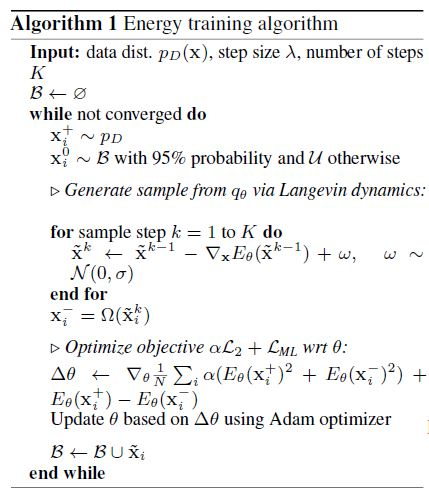

In [23]:
class ResBlock(nn.Module):
    #stride?
    def __init__(self, in_size, out_size, stride=1):
        super(ResBlock, self).__init__()

        self.stride = stride
        self.conv_block1 = nn.Conv2d(in_size, out_size, kernel_size=3, stride=1, padding=1)
        self.conv_block2 = nn.Conv2d(out_size, out_size, kernel_size=3, stride=1, padding=1)
        # self.batch_norm = nn.BatchNorm2d(out_size)
        self.avgPool = nn.AvgPool2d(kernel_size=stride, stride=stride)

        self.identity_pad = nn.Sequential()
        if in_size != out_size or stride != 1: # we don't want to change dim for the 1st residual block layers, why?
            self.identity_pad = nn.Sequential(nn.Conv2d(in_size, out_size, kernel_size=1, stride=1))

    def forward(self, x):
        if self.stride > 1:
            x = self.avgPool(x)
        out_block = self.conv_block1(x)
        out_block = F.leaky_relu(out_block)
        out_block = self.conv_block2(out_block)
        out_block = F.leaky_relu(out_block)
        return out_block + self.identity_pad(x)

In [24]:
def res_block_layers(in_size, out_size, num_res_block, stride=1):
    layers = []

    #append the first layer
    layers.append(ResBlock(in_size, out_size, stride))

    #append the remaining layers
    for i in range(1, num_res_block):
        layers.append(ResBlock(out_size, out_size))
        
    return nn.Sequential(*layers)

In [25]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()

        self.conv = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3)
        self.batch_norm = nn.BatchNorm2d(64) 
        self.maxPool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) #check the numbers? why??

        self.res_block1 = res_block_layers(64, 64, 3, stride=1)
        self.res_block2 = res_block_layers(64, 128, 4, stride=2)
        self.res_block3 = res_block_layers(128, 256, 6, stride=2)
        self.res_block4 = res_block_layers(256, 512, 3, stride=2)

        self.avgPool = nn.AvgPool2d((1,1)) 
        self.linear = nn.Linear(512, 1)

    def forward(self, x):
        x = self.conv(x)
        # x = self.batch_norm(x)
        x = F.leaky_relu(x)
        x = self.maxPool(x)

        #residual blocks
        x = self.res_block1(x) 
        x = self.res_block2(x) 
        x = self.res_block3(x) 
        x = self.res_block4(x)

        #check size?
        x = self.avgPool(x)

        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

In [32]:
BATCH_SIZE = 128
MAX_BUFFER_SIZE = 10000

In [33]:
mnist_transform =torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
mnist_train = MNIST(root='./data', train=True, download=True, transform=mnist_transform)
mnist_test =  MNIST(root='./data', train=False, download=True, transform=mnist_transform)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1) # REMARK: we don't need test data!

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(device)
B = []
learning_rate = 1e-4

alpha = 1e-3
sigma = 0.005
lambdaa = 10.
input_size = 28*28
output_size = 1

# Number of Langevin Dynamics steps
K = 60

cuda:0


In [35]:
def sample(net, B, shape, lmbda, sigma, device, n_steps=K):
    ''' samples one image with Langevin dynamics '''
    # Get our `x0` either from uniform noise or reply buffer
    shape = list(shape)
    if np.random.random_sample() > 0.95 or len(B) == 0:
        x0 = torch.rand(*shape, device=device)
    else:
        x0 = np.random.choice(B).to(device) # TODO: split by first dim when putting in buffer

    # x = x0.clone().detach()
    x = x0
    x = x.detach()
    x.requires_grad = True
    # print(x.shape)
    for k in range(n_steps):
        w = torch.normal(torch.zeros(shape, device=device), sigma * torch.ones(shape, device=device))
        outputs = torch.sum(net(x))
        grad = torch.autograd.grad(outputs=outputs, inputs=x)[0]
        grad_clipped = torch.clip(grad, -0.01, +0.01)
        x = x - (lmbda/2) * grad_clipped + w
        # TODO: clip `x` to make sure it stays in bounds
        x = x.detach()
        x.requires_grad = True
        x = torch.clip(x, 0, 1)
    return x


def loss_fcn(net, x_pos, x_neg, alpha):
    loss_pos = torch.mean(alpha*(net(x_pos)**2) + net(x_pos))
    loss_neg = torch.mean(alpha*(net(x_neg)**2) - net(x_neg))
    return (loss_pos + loss_neg) / 2
    # return torch.mean(alpha*(net(x_pos)**2 + net(x_neg)**2) + net(x_pos) - net(x_neg))

In [40]:
n_epochs = 10
net = ResNet().to(device)
optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=(0.0, 0.999)) 


B = []
n_epochs = 1
train_load_iter = iter(train_loader)

for epoch in range(n_epochs):
    total_loss = 0
    # progress bar
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=len(train_loader), position=0, leave=True) 

    for i, data in progress:
        x_pos, labels = data[0].to(device), data[1].to(device, dtype=torch.int64)
        optimizer.zero_grad()
        x_neg = sample(net, B, x_pos.shape, lambdaa, sigma, device).detach()
        B.append(x_neg)
        B = B[-MAX_BUFFER_SIZE:]
        running_loss = 0
        loss = loss_fcn(net, x_pos, x_neg, alpha)
        # TODO: clip gradients?
        loss.backward()
        optimizer.step()
        current_loss = loss.item()
        total_loss += current_loss

        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))
        if i > 5:
            break

Loss: -0.0052:   1%|▏         | 6/469 [00:26<29:28,  3.82s/it]

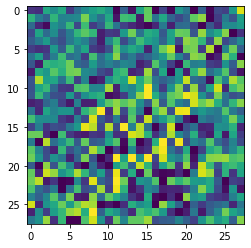

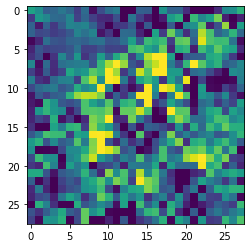

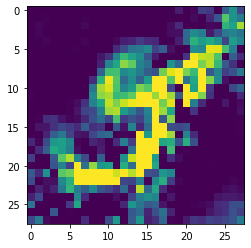

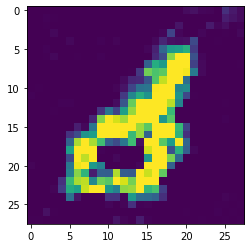

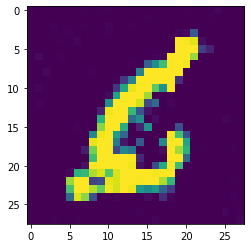

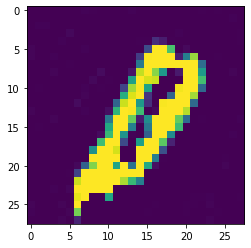

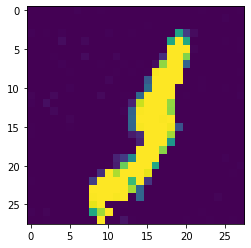

In [ ]:
def print_sample(x):
    plt.figure()
    x = x[0]
    plt.imshow(x.view(28, 28).detach().cpu())

# print(x_pos.shape)
# assert False
input_shape = [1, 1, 28, 28]
# input_shape = x_pos.shape
for n_steps in [10, 20, 50, 100, 200, 500, 1000]:
    # x_neg = sample(net, B, x_pos.shape, lambdaa, sigma, device).detach()
    x_sample = sample(net, [], input_shape, lambdaa, sigma, device, n_steps)
    print_sample(x_sample)

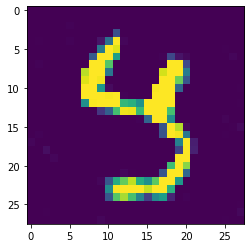

In [ ]:
# print(B)
print_sample(B[-1])